# Prévisions météo en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [4]:
# récupération du package scikit-plot
!pip install scikit-plot

In [5]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [15]:
# récupération des librairies
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist
from scipy.stats import chi2_contingency

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso, LassoCV, lasso_path, RidgeCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Modèles de classification par apprentissage supervisé

In [7]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0,1,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0,1,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0,1,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0,1,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0,1,0,0,0


In [9]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [10]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [ ]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts

In [11]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [ ]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts

In [12]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [13]:
# oversampling des données
# rOs = RandomOverSampler()
# X_ro, y_ro = rOs.fit_resample(X_train, y_train)
# print("Cardinalité des classes de la variable cible sur-échantillonnée:", dict(pd.Series(y_ro).value_counts()))

In [16]:
# undersampling des données
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print("Cardinalité des classes de la variable cible sous-échantillonnée:", dict(pd.Series(y_train_ru).value_counts()))

Classes échantillon undersampled : {0: 25005, 1: 25005}


In [17]:
# distribution de la variable cible dans l'ensemble de test
y_train_ru.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [18]:
# paramètre à initialiser pour calculer les performances des algorithmes avec ré-échantillonage
param_ru = 'under_sample'

if param_ru == 'under_sample':
    X_train = X_train_ru
    y_train = y_train_ru

In [19]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Régression Logistique

In [22]:
# définition du modèle
clf_lr = LogisticRegression()

# param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
#                  'C':np.linspace(0.1,1,10)}

param_grid_lr = {'solver':['liblinear'], 
                 'C':np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3)

In [23]:
start_time = time.time()

# entraînement
gcv_lr.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'C': 0.2, 'solver': 'liblinear'} 

Accuracy Score: 0.7790681156332125 

Train Data Score: 0.7733053389322135
Test Data Score: 0.7790681156332125

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17189  4773
1             1448  4748

               precision    recall  f1-score   support

           0       0.92      0.78      0.85     21962
           1       0.50      0.77      0.60      6196

    accuracy                           0.78     28158
   macro avg       0.71      0.77      0.73     28158
weighted avg       0.83      0.78      0.79     28158

Running Time: 0:00:02.130943


- la méthode de régression logistique ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.77.
- la spécificité (taux de vrais négatifs) vaut 0.78.
- le F1-score concernant la classe '0' de la variable RainTomorrow est bon (0.85).
- le F1-score concernant la classe '1' de la variable RainTomorrow est faible (0.60).

In [24]:
cv_scores = cross_val_score(gcv_lr, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.77096581 0.77318536 0.77624475]
Average cross-validation score: 0.7734653069386123


- Le score de la méthode de régression logistique est en moyenne de : 0.77.

In [26]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_lr_' + param_ru]).to_csv('scores/scores_clf_lr_' + param_ru + '.csv')

In [27]:
# courbe ROC (Receiver Operating Characteristic) pour le modèle de régression logistique
y_pred_logreg_proba = gcv_lr.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba[:,1])

In [28]:
# aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
print("Aire sous la courbe =", roc_auc)

Aire sous la courbe = 0.8576790658246544


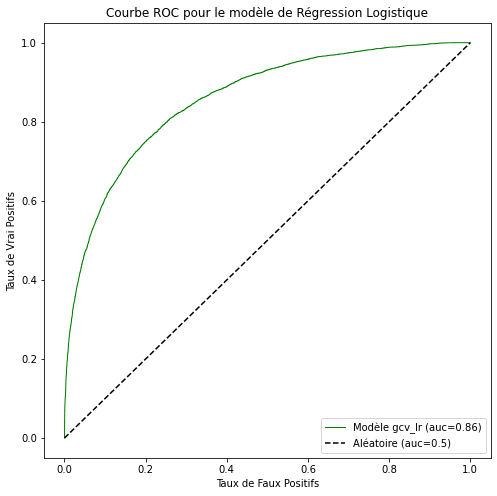

In [29]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, '-g', linewidth=1, label='Modèle gcv_lr (auc=%0.2f)' %roc_auc)
plt.plot([0,1], [0,1], 'k--', label='Aléatoire (auc=0.5)')
plt.title('Courbe ROC pour le modèle de Régression Logistique')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrai Positifs')
plt.legend(loc="lower right");


- La courbe ROC est l'outil idéal pour résumer la performance d'un classifieur binaire en fonction de tous les seuils possibles. Elle évite un long travail de prédictions de classes pour différents seuils, et d'évaluation de la matrice de confusion pour chacun de ces seuils.
- Graphiquement, la mesure ROC est représentée sous la forme d'une courbe qui donne le taux de vrais positifs (la sensibilité), en fonction du taux de faux positifs (l'antispécificité).
- Plus la courbe se rapproche du point (0,1), meilleures sont les prédictions. Un modèle avec une sensibilité et une spécificité égales à 1 est considéré comme parfait.



## Forêts Aléatoires

In [30]:
# définition du modèle
clf_rf  = RandomForestClassifier() # les forêts aléatoires ne gèrent pas les variables qualitatives

param_grid_rf  = [{'n_estimators' : [50, 100, 150],
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf)

In [31]:
start_time = time.time()

# entraînement
gcv_rf.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150} 

Accuracy Score: 0.7940194616094893 

Train Data Score: 0.9436712657468507
Test Data Score: 0.7940194616094893

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17514  4448
1             1352  4844
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     21962
           1       0.52      0.78      0.63      6196

    accuracy                           0.79     28158
   macro avg       0.72      0.79      0.74     28158
weighted avg       0.84      0.79      0.81     28158

Running Time: 0:11:50.949642


- la méthode de forêt aléatoire fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.78.
- la spécificité (taux de vrais négatifs) vaut 0.80.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.86).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.63).

In [32]:
cv_scores = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.78596281 0.78560288 0.78836233]
Average cross-validation score: 0.786642671465707


- Le score de la méthode des forêts aléatoires est en moyenne de : 0.79.

In [34]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_rf_' + param_ru]).to_csv('scores/scores_clf_rf_' + param_ru + '.csv')

In [35]:
# probabilités pour X_test_scaled d'appartenir à chacune des deux classes
y_probas = gcv_rf.predict_proba(X_test_scaled)

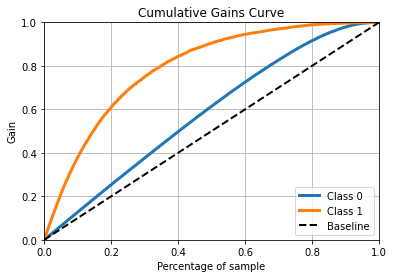

In [36]:
# courbe de gain cumulée
skplt.metrics.plot_cumulative_gain(y_test, y_probas);

- L'axe horizontal représente les individus de l'échantillon test.
- L'axe vertical représente la variable cible "RainTomorrow".

## Support Vector Machine

In [37]:
# définition du modèle
clf_svm = svm.SVC()

# le temps de calcul est élevé lors d'une régularisation des paramètres de la fonction noyau
# param_grid_svm = {'kernel' : ['rbf','linear','poly'], 
#                   'gamma' : [0.001, 0.1, 0.5]}

param_grid_svm = {'kernel' : ['rbf'], 
                  'gamma' : [0.01, 0.1, 0.5]}

gcv_svm = GridSearchCV(clf_svm, param_grid_svm)

In [38]:
start_time = time.time()

# entraînement
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_svm.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'gamma': 0.1, 'kernel': 'rbf'} 

Accuracy Score: 0.796576461396406 

Train Data Score: 0.7954409118176364
Test Data Score: 0.796576461396406

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17610  4352
1             1376  4820
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     21962
           1       0.53      0.78      0.63      6196

    accuracy                           0.80     28158
   macro avg       0.73      0.79      0.74     28158
weighted avg       0.84      0.80      0.81     28158

Running Time: 1:09:45.812581


- la méthode SVM ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.78.
- la spécificité (taux de vrais négatifs) vaut 0.80.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.86).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.63).

In [39]:
cv_scores = cross_val_score(gcv_svm, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.78464307 0.7860228  0.78812238]
Average cross-validation score: 0.7862627474505098


- Le score de la méthode SVM est en moyenne de : 0.79.

In [40]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_svm_' + param_ru]).to_csv('scores/scores_clf_svm_' + param_ru + '.csv')

In [41]:
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params','mean_test_score']])

                             params  mean_test_score
0  {'gamma': 0.01, 'kernel': 'rbf'}         0.780984
1   {'gamma': 0.1, 'kernel': 'rbf'}         0.787163
2   {'gamma': 0.5, 'kernel': 'rbf'}         0.783563
3     {'gamma': 1, 'kernel': 'rbf'}         0.779404


In [42]:
# courbe d'apprentissage du modèle (prend beaucoup trop de temps)
# train_sizes, train_scores, valid_scores = learning_curve(svm.SVC(kernel='linear', C=1), data, target, train_sizes=[50, 80, 110, 140], cv=5)
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_sizes = [50, 70, 80, 100, 110, 118]
# train_sizes, train_scores, test_scores = learning_curve(gcv_svm, data, target, n_jobs=4, train_sizes=train_sizes)

# train_score_mean = np.mean(train_scores, axis=1)
# train_score_std = np.std(train_scores, axis=1)
# test_score_mean = np.mean(test_scores, axis=1)
# test_score_std = np.std(test_scores, axis=1)

# plt.grid()
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# plt.legend(loc="best");

## K-plus proches voisins

In [43]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(20,41,1),
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn)

In [44]:
start_time = time.time()

# entraînement
gcv_knn.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'metric': 'minkowski', 'n_neighbors': 33} 

Accuracy Score: 0.792030683997443 

Train Data Score: 0.7924815036992602
Test Data Score: 0.792030683997443

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17492  4470
1             1386  4810
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     21962
           1       0.52      0.78      0.62      6196

    accuracy                           0.79     28158
   macro avg       0.72      0.79      0.74     28158
weighted avg       0.84      0.79      0.80     28158

Running Time: 0:30:36.672307


- la méthode des K-plus proches voisins ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.78.
- la spécificité (taux de vrais négatifs) vaut 0.80.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.86).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.62).

In [45]:
cv_scores = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.77594481 0.77624475 0.7824835 ]
Average cross-validation score: 0.7782243551289741


- Le score de la méthode KNN est en moyenne de : 0.78.

In [46]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_knn_' + param_ru]).to_csv('scores/scores_clf_knn_' + param_ru + '.csv')

In [47]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev pour des valeurs de k allant de 1 à 40
# temps de calcul : ~ 12 min.
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

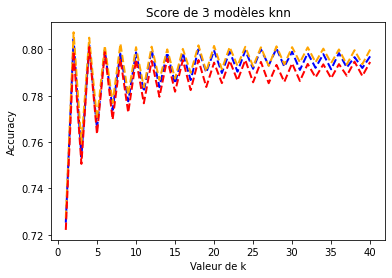

In [48]:
# affichage des listes crées en fonction de k
plt.title("Score de 3 modèles knn")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.xlabel("Valeur de k")
plt.ylabel("Accuracy")
plt.legend;

## Arbres de décision

In [49]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt)

In [50]:
start_time = time.time()

# entraînement
gcv_dt.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'criterion': 'entropy', 'max_depth': 5} 

Accuracy Score: 0.7727111300518503 

Train Data Score: 0.7601079784043191
Test Data Score: 0.7727111300518503

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17218  4744
1             1656  4540
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     21962
           1       0.49      0.73      0.59      6196

    accuracy                           0.77     28158
   macro avg       0.70      0.76      0.71     28158
weighted avg       0.82      0.77      0.79     28158

Running Time: 0:00:02.275700


- la méthode des arbres de décision ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.73.
- la spécificité (taux de vrais négatifs) vaut 0.78.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.84).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.59).

In [51]:
# importance des variables
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.661755
Sunshine,0.138992
WindGustSpeed,0.081032
Pressure9am,0.071098
Rainfall,0.036070
Temp_Delta_MinMax,0.005014
Humidity_Delta,0.003218
Temp3pm,0.002498


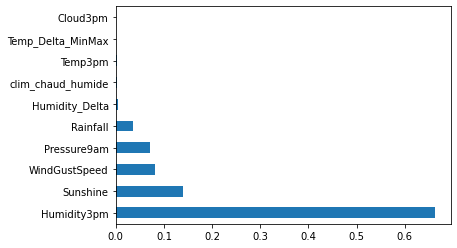

In [52]:
# importance des variables
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh');

In [53]:
cv_scores = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.75476905 0.75302939 0.75476905]
Average cross-validation score: 0.7541891621675664


- Le score de la méthode DT est en moyenne de : 0.76.

In [54]:
# sauvegarde des scores dans un fichier de sortie
pd.DataFrame([f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['f1','recall','precision'], 
             columns=['scores_clf_dt_' + param_ru]).to_csv('scores/scores_clf_dt_' + param_ru + '.csv')

# Résumé des performances

In [56]:
scores_clf_dt_under_sample = pd.read_csv('scores/scores_clf_dt_under_sample.csv', index_col=0)
scores_clf_knn_under_sample = pd.read_csv('scores/scores_clf_knn_under_sample.csv', index_col=0)
scores_clf_svm_under_sample = pd.read_csv('scores/scores_clf_svm_under_sample.csv', index_col=0)
scores_clf_rf_under_sample = pd.read_csv('scores/scores_clf_rf_under_sample.csv', index_col=0)
scores_clf_lr_under_sample = pd.read_csv('scores/scores_clf_lr_under_sample.csv', index_col=0)

In [57]:
result_under_sample = pd.concat([scores_clf_dt_under_sample, scores_clf_knn_under_sample, scores_clf_svm_under_sample,
                    scores_clf_rf_under_sample, scores_clf_lr_under_sample], axis=1)

In [58]:
result_under_sample

,scores_clf_dt_under_sample,scores_clf_knn_under_sample,scores_clf_svm_under_sample,scores_clf_rf_under_sample,scores_clf_lr_under_sample
f1,0.586563,0.617278,0.627277,0.625517,0.604187
recall,0.732731,0.773241,0.777921,0.781795,0.766301
precision,0.489013,0.513670,0.525512,0.521309,0.498687
